In [1]:
import glob
import os
import re
import sys
from collections import defaultdict
from functools import reduce, partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from pymutspec.annotation.spectra import get_cossim, complete_sbs192_columns, collapse_sbs192
from pymutspec.annotation import CodonAnnotation, rev_comp
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.draw import plot_mutspec192, plot_mutspec12
import pymutspec

from Bio import SeqIO, AlignIO
from Bio.Data import CodonTable
from Bio.SeqRecord import SeqRecord
from Bio.Align.AlignInfo import SummaryInfo
from scipy import spatial

import warnings
warnings.filterwarnings("ignore")

In [2]:
coda = CodonAnnotation(gencode=2)

## Collect obs

In [150]:
outdir = '/home/kpotoh/nemu-pipeline/data/chordata2/output'
paths_msa = glob.glob(outdir + '/*/*/msa_nuc.fasta') 
len(paths_msa)

9252

In [152]:
def read_ingroup_msa(path):
    msa = AlignIO.read(path, 'fasta')
    for i,x in enumerate(msa):
        if x.name == 'OUTGRP':
            break
    assert msa[i].name == 'OUTGRP'
    del msa[i]
    return msa


def collect_snp_from_consensus(rec: SeqRecord, consensus: str):
    muts = coda.extract_mutations_simple(consensus, str(rec.seq))
    return muts

### Test

In [5]:
msa = read_ingroup_msa(paths_msa[10])
si = SummaryInfo(msa)
consensus = str(si.dumb_consensus())

In [6]:
data = []
for i, rec in enumerate(msa):
    m = collect_snp_from_consensus(rec, consensus)
    if len(m):
        data.append(m.assign(seq_id=i))

In [7]:
df = pd.concat(data)
df.head()

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,seq_id
0,T[A>G]C,1,258,3,ATA,ATG,M,M,0
1,C[T>C]G,2,549,3,CCT,CCC,P,P,0
0,C[A>G]A,2,309,3,TCA,TCG,S,S,1
0,C[A>G]C,2,606,3,GCA,GCG,A,A,2
1,G[A>G]T,2,648,3,GGA,GGG,G,G,2


In [8]:
df.groupby(['PosInGene', 'Mut']).Label.count().sort_index()

PosInGene  Mut    
54         C[A>C]C    7
78         T[A>G]A    5
81         C[A>G]C    1
84         T[G>A]C    3
90         A[A>G]C    2
                     ..
900        T[C>G]C    2
903        C[T>C]A    1
940        A[G>A]C    1
941        G[C>T]G    1
942        C[G>A]A    1
Name: Label, Length: 168, dtype: int64

<AxesSubplot:>

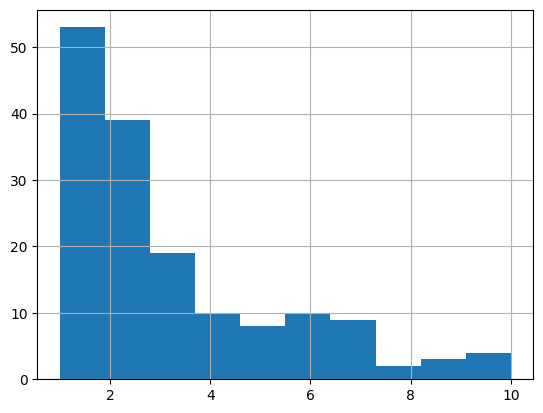

In [9]:
df.seq_id.value_counts().hist()

### Collect obs muts

In [56]:
def milti_collect(x, consensus):
    i, rec = x
    m = collect_snp_from_consensus(rec, consensus)
    if len(m):
        m = m.assign(seq_id=i)
    return m

p = Pool(64)

In [62]:
_ = p.map(partial(milti_collect, consensus=consensus), enumerate(msa))
x = pd.concat(_, ignore_index=True)

In [67]:
data = []
nseqs = []

j = 0
for path_fasta in tqdm.tqdm(paths_msa):
    j += 1
    p_elements = path_fasta.split('/')
    gene_species = p_elements[8]

    msa = read_ingroup_msa(path_fasta)
    nseqs.append([gene_species, len(msa)])
    si = SummaryInfo(msa)
    consensus = si.dumb_consensus(0.5, 'N')
    
    muts_from_seqs_lst = p.map(partial(milti_collect, consensus=consensus), enumerate(msa))
    muts_from_seqs_lst = [x for x in muts_from_seqs_lst if len(x)]
    # muts_from_seqs_lst = []
    # for i, rec in enumerate(msa):
    #     m = collect_snp_from_consensus(rec, consensus)
    #     if len(m):
    #         muts_from_seqs_lst.append(m.assign(seq_id=i))

    if len(muts_from_seqs_lst):
        mut = pd.concat(muts_from_seqs_lst, ignore_index=True).assign(gene_species=gene_species)
        data.append(mut)
    
    # if j > 10:
    #     break

obs_poly = pd.concat(data, ignore_index=True)
obs_poly.to_csv('../data/chordata2/obs_muts_poly.csv', index=False)

pd.DataFrame(nseqs, columns=['gene_species', 'nseqs']).to_csv('../data/chordata2/nseqs.csv', index=False)

100%|██████████| 9252/9252 [21:59<00:00,  7.01it/s]  


In [69]:
obs_poly

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,seq_id,gene_species
0,C[A>G]T,0,25,1,ATT,GTT,I,V,0,ND1__Eleotris_fusca
1,C[G>A]G,2,645,3,TCG,TCA,S,S,0,ND1__Eleotris_fusca
2,T[A>G]C,1,876,3,ATA,ATG,M,M,0,ND1__Eleotris_fusca
3,T[T>C]C,2,57,3,GTT,GTC,V,V,1,ND1__Eleotris_fusca
4,C[C>T]G,2,564,3,GCC,GCT,A,A,1,ND1__Eleotris_fusca
...,...,...,...,...,...,...,...,...,...,...
3782440,A[C>T]G,1,192,3,CAC,CAT,H,H,6,ND4L__Branchiostoma_belcheri
3782441,C[A>G]C,2,12,3,ACA,ACG,T,T,7,ND4L__Branchiostoma_belcheri
3782442,G[T>C]T,2,93,3,GGT,GGC,G,G,8,ND4L__Branchiostoma_belcheri
3782443,A[A>G]A,1,9,3,CAA,CAG,Q,Q,9,ND4L__Branchiostoma_belcheri


## Filter out ambigous positions and derive spectra

### Collect bad sites

In [96]:
# need to filter out amb msa columns (sites), i.e. drop mutations from these sites

thr0 = 0.50
thr1 = 0.05
thr2 = 0.05

j = 0
bad_sites = []
for path_fasta in tqdm.tqdm(paths_msa[2:]):
    j += 1
    p_elements = path_fasta.split('/')
    gene_species = p_elements[8]

    msa = read_ingroup_msa(path_fasta)
    si = SummaryInfo(msa)
    pssm = si.pos_specific_score_matrix().pssm
    
    nseqs = len(msa)
    ncols = msa.get_alignment_length()

    i = 0
    for site, (nuc, counts) in enumerate(pssm):
        counts_sorted = sorted(counts.values(), reverse=True)
        freqs_sorted = [x / sum(counts_sorted) for x in counts_sorted]
        if freqs_sorted[0] < thr0 or freqs_sorted[1] >= thr1 or freqs_sorted[2] >= thr2:
            # print(counts)
            i += 1
            bad_sites.append([gene_species, site, [round(x,2) for x in freqs_sorted]])

    # print(f'{gene_species} - amb cols: {i}, {i/ncols:.3f}%')

    # if j > 2:
    #     break

  0%|          | 26/9250 [00:05<36:49,  4.17it/s] 

In [ ]:
bad_sites_df = pd.DataFrame(bad_sites, columns=['gene_species', 'site', 'freqs_sorted'])
bad_sites_df.to_csv('../data/chordata2/bad_sites.XXXX.csv', index=False)

### Get spectra

In [3]:
obs_poly = pd.read_csv("../data/chordata2/obs_muts_poly.csv")
obs_poly.rename(columns={'PosInGene': 'site'}, inplace=True)
obs_poly.head()

,Mut,Label,site,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,seq_id,gene_species
0,C[A>G]T,0,25,1,ATT,GTT,I,V,0,ND1__Eleotris_fusca
1,C[G>A]G,2,645,3,TCG,TCA,S,S,0,ND1__Eleotris_fusca
2,T[A>G]C,1,876,3,ATA,ATG,M,M,0,ND1__Eleotris_fusca
3,T[T>C]C,2,57,3,GTT,GTC,V,V,1,ND1__Eleotris_fusca
4,C[C>T]G,2,564,3,GCC,GCT,A,A,1,ND1__Eleotris_fusca


In [4]:
bad_sites_df2520 = pd.read_csv('../data/chordata2/bad_sites.25.20.csv', 
                               usecols=['gene_species', 'site']).assign(amb=True)
bad_sites_df1510 = pd.read_csv('../data/chordata2/bad_sites.15.10.csv', 
                               usecols=['gene_species', 'site']).assign(amb=True)
bad_sites_df0505 = pd.read_csv('../data/chordata2/bad_sites.05.05.csv', 
                               usecols=['gene_species', 'site']).assign(amb=True)

bad_sites_df2520["site"] += 1
bad_sites_df1510["site"] += 1
bad_sites_df0505["site"] += 1

In [5]:
bad_sites_df1510#.assign(amb=True)#["site"].min()|

,gene_species,site,amb
0,ND1__Anaxyrus_fowleri,24,True
1,ND1__Anaxyrus_fowleri,36,True
2,ND1__Anaxyrus_fowleri,69,True
3,ND1__Anaxyrus_fowleri,153,True
4,ND1__Anaxyrus_fowleri,162,True
...,...,...,...
334284,ND4L__Branchiostoma_belcheri,93,True
334285,ND4L__Branchiostoma_belcheri,102,True
334286,ND4L__Branchiostoma_belcheri,126,True
334287,ND4L__Branchiostoma_belcheri,159,True


In [19]:
obs_poly2520 = obs_poly.merge(bad_sites_df2520, 'left', ['gene_species', 'site'])
obs_poly1510 = obs_poly.merge(bad_sites_df1510, 'left', ['gene_species', 'site'])
obs_poly0505 = obs_poly.merge(bad_sites_df0505, 'left', ['gene_species', 'site'])

obs_poly2520['amb'] = obs_poly2520['amb'].fillna(False)
obs_poly1510['amb'] = obs_poly1510['amb'].fillna(False)
obs_poly0505['amb'] = obs_poly0505['amb'].fillna(False)

In [23]:
obs_poly0505.head()

,Mut,Label,site,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,seq_id,gene_species,amb
0,C[A>G]T,0,25,1,ATT,GTT,I,V,0,ND1__Eleotris_fusca,False
1,C[G>A]G,2,645,3,TCG,TCA,S,S,0,ND1__Eleotris_fusca,False
2,T[A>G]C,1,876,3,ATA,ATG,M,M,0,ND1__Eleotris_fusca,False
3,T[T>C]C,2,57,3,GTT,GTC,V,V,1,ND1__Eleotris_fusca,False
4,C[C>T]G,2,564,3,GCC,GCT,A,A,1,ND1__Eleotris_fusca,False


In [24]:
obs_poly2520.shape, obs_poly1510.shape, obs_poly0505.shape

((3782445, 11), (3782445, 11), (3782445, 11))

In [21]:
obs_poly2520.drop_duplicates(['gene_species', 'site']).amb.sum(), obs_poly1510.drop_duplicates(['gene_species', 'site']).amb.sum(), obs_poly0505.drop_duplicates(['gene_species', 'site']).amb.sum()

(178889, 290150, 531937)

In [23]:
bad_sites_df2520.shape, bad_sites_df1510.shape, bad_sites_df0505.shape,

((208254, 3), (334289, 3), (748202, 3))

In [114]:
obs_poly_freqs = complete_sbs192_columns(obs_poly[(obs_poly.Label > 0)].groupby(['gene_species'])\
    .Mut.value_counts().unstack().fillna(0.))
obs_poly2520freqs = complete_sbs192_columns(obs_poly2520[(~obs_poly2520.amb) & (obs_poly2520.Label > 0)].groupby(['gene_species'])\
    .Mut.value_counts().unstack().fillna(0.))
obs_poly1510freqs = complete_sbs192_columns(obs_poly1510[(~obs_poly1510.amb) & (obs_poly1510.Label > 0)].groupby(['gene_species'])\
    .Mut.value_counts().unstack().fillna(0.))
obs_poly0505freqs = complete_sbs192_columns(obs_poly0505[(~obs_poly0505.amb) & (obs_poly0505.Label > 0)].groupby(['gene_species'])\
    .Mut.value_counts().unstack().fillna(0.))

In [80]:
obs_poly2520freqs

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
gene_species,,,,,,,,,,,,,,,,,,,,,
A6__Acanthurus_nigricans,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A6__Acanthurus_triostegus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A6__Adelomyia_melanogenys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
A6__Agkistrodon_contortrix,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A6__Agkistrodon_piscivorus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND6__Vidua_purpurascens,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ND6__Vireo_olivaceus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ND6__Vireo_solitarius,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

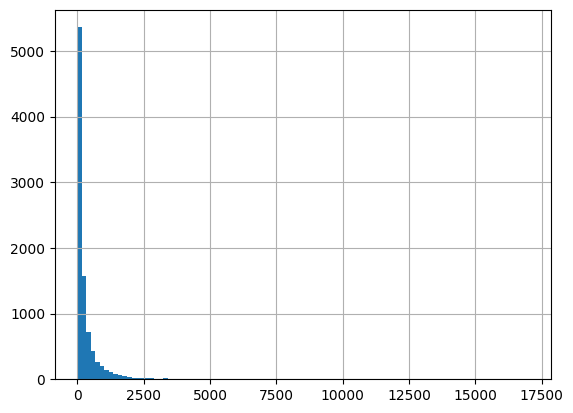

In [115]:
obs_poly_freqs.sum(axis=1).hist(bins=100)

<AxesSubplot:>

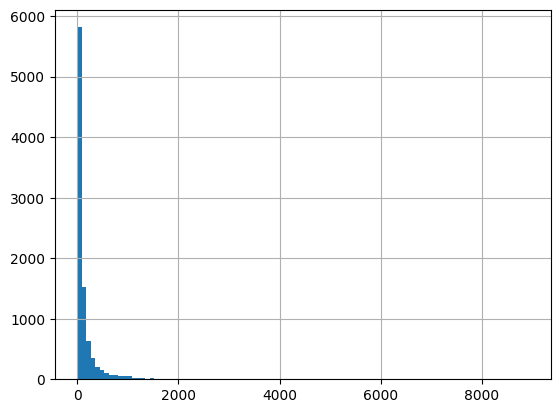

In [81]:
obs_poly2520freqs.sum(axis=1).hist(bins=100)

<AxesSubplot:>

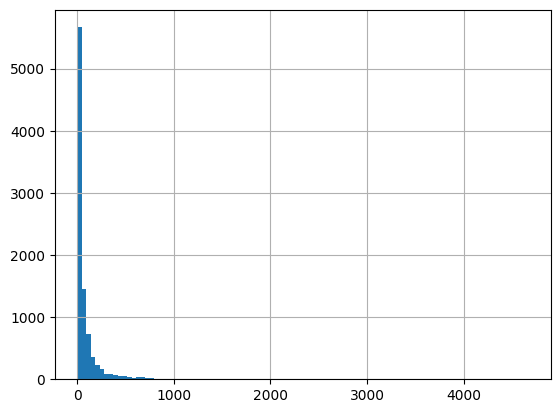

In [82]:
obs_poly1510freqs.sum(axis=1).hist(bins=100)

<AxesSubplot:>

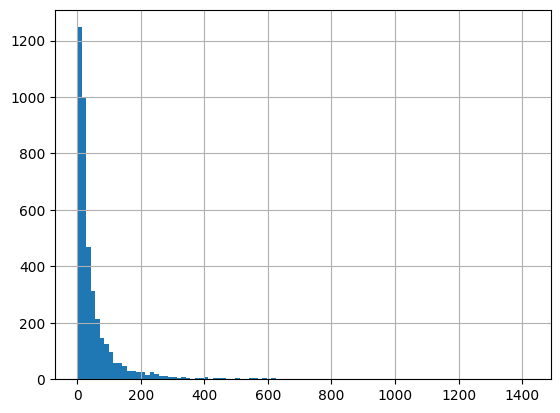

In [83]:
obs_poly0505freqs.sum(axis=1).hist(bins=100)

In [116]:
obs_poly_freqs12 = collapse_sbs192(obs_poly_freqs)[possible_sbs12]
obs_poly2520freqs12 = collapse_sbs192(obs_poly2520freqs)[possible_sbs12]
obs_poly1510freqs12 = collapse_sbs192(obs_poly1510freqs)[possible_sbs12]
obs_poly0505freqs12 = collapse_sbs192(obs_poly0505freqs)[possible_sbs12]

In [89]:
obs_poly2520freqs12

Mut,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
gene_species,,,,,,,,,,,,
A6__Acanthurus_nigricans,0.0,10.0,0.0,1.0,0.0,8.0,2.0,0.0,1.0,0.0,6.0,0.0
A6__Acanthurus_triostegus,3.0,29.0,0.0,0.0,0.0,54.0,1.0,1.0,0.0,0.0,42.0,0.0
A6__Adelomyia_melanogenys,0.0,176.0,35.0,27.0,14.0,305.0,0.0,15.0,0.0,7.0,168.0,1.0
A6__Agkistrodon_contortrix,1.0,10.0,1.0,2.0,0.0,15.0,5.0,0.0,0.0,0.0,9.0,0.0
A6__Agkistrodon_piscivorus,0.0,7.0,0.0,0.0,0.0,7.0,10.0,0.0,0.0,0.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
ND6__Vidua_purpurascens,0.0,3.0,0.0,0.0,0.0,6.0,2.0,0.0,4.0,0.0,6.0,0.0
ND6__Vireo_olivaceus,0.0,13.0,0.0,0.0,0.0,9.0,2.0,0.0,4.0,0.0,7.0,0.0
ND6__Vireo_solitarius,0.0,1.0,0.0,0.0,0.0,9.0,2.0,0.0,2.0,0.0,10.0,0.0


### Calc snp spectrum

In [92]:
exp = pd.read_csv('../data/chordata2/exp_num.csv', index_col=0)
exp.head()

,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
gene__species,,,,,,,,,,,,,,,,,,,,,
ND1__Eleotris_fusca,NaN,NaN,NaN,NaN,14.076923,8.461538,13.000000,6.769231,2.000000,NaN,...,82.230769,58.230769,58.230769,137.923077,24.307692,15.384615,15.384615,23.076923,61.461538,23.076923
ND1__Lasiurus_blossevillii,NaN,NaN,NaN,NaN,7.909091,9.636364,6.090909,10.272727,1.909091,NaN,...,72.090909,35.909091,35.909091,93.909091,22.727273,9.000000,9.000000,29.000000,93.181818,29.000000
ND1__Anaxyrus_fowleri,NaN,NaN,NaN,NaN,13.039216,8.490196,9.215686,5.568627,1.921569,3.901961,...,71.039216,44.098039,44.098039,79.411765,14.235294,7.176471,7.176471,40.823529,108.960784,40.823529
ND1__Lichanura_trivirgata,NaN,NaN,NaN,NaN,21.000000,10.600000,13.430769,17.323077,1.907692,3.953846,...,99.430769,41.215385,41.215385,114.953846,20.646154,11.000000,11.000000,12.261538,29.292308,12.261538
ND1__Anaxyrus_woodhousii,NaN,NaN,NaN,NaN,14.962264,10.660377,9.830189,5.754717,1.981132,3.905660,...,78.660377,41.000000,41.000000,82.698113,12.603774,6.471698,6.471698,42.792453,111.075472,42.792453


In [108]:
def calc_spectra(obs_freqs: pd.DataFrame, exp_freqs: pd.DataFrame):
    assert (obs_freqs.columns == exp_freqs.columns).all()
    ind = obs_freqs.index.intersection(exp_freqs.index)
    obs_freqs = obs_freqs.loc[ind]
    exp_freqs = exp_freqs.loc[ind]
    assert (obs_freqs.index == exp_freqs.index).all()

    sp = (obs_freqs / exp_freqs).replace(np.inf, 0.)
    sp = (sp.T / sp.sum(axis=1)).T.fillna(0.)
    return sp


In [119]:
spectra0000_12 = calc_spectra(obs_poly_freqs12, exp[possible_sbs12])
spectra2520_12 = calc_spectra(obs_poly2520freqs12, exp[possible_sbs12])
spectra1510_12 = calc_spectra(obs_poly1510freqs12, exp[possible_sbs12])
spectra0505_12 = calc_spectra(obs_poly0505freqs12, exp[possible_sbs12])

spectra0000_192 = calc_spectra(obs_poly_freqs, exp[possible_sbs192])
spectra2520_192 = calc_spectra(obs_poly2520freqs, exp[possible_sbs192])
spectra1510_192 = calc_spectra(obs_poly1510freqs, exp[possible_sbs192])
spectra0505_192 = calc_spectra(obs_poly0505freqs, exp[possible_sbs192])

### Compare with main dataset

In [123]:
obs12 = pd.read_csv('../data/chordata2/obs_num12.csv', index_col=0).fillna(0.)
obs192 = pd.read_csv('../data/chordata2/obs_num192.csv', index_col=0).fillna(0.)
spectra12 = pd.read_csv('../data/chordata2/spectra12.csv', index_col=0).fillna(0.)
spectra192 = pd.read_csv('../data/chordata2/spectra192.csv', index_col=0).fillna(0.)
obs192.head()

,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
gene__species,,,,,,,,,,,,,,,,,,,,,
A6__Acanthurus_triostegus,0.0,0.0,0.0,0.0,0.00000,0.973268,0.0,0.99938,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A6__Adelomyia_melanogenys,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
A6__Agkistrodon_contortrix,0.0,0.0,0.0,0.0,0.99947,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A6__Agkistrodon_piscivorus,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A6__Alethe_diademata,0.0,0.0,0.0,0.0,0.00000,1.142050,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
for df_snp, lbl in zip(
    [spectra0000_12, spectra2520_12, spectra1510_12, spectra0505_12],
    ['spectra0000_12', 'spectra2520_12', 'spectra1510_12', 'spectra0505_12']
):
    cossim = get_cossim(spectra12, df_snp)
    print(lbl)
    print(f'size: {cossim.shape[0]}\nmedian: {cossim.median():.2f}\nmean: {cossim.mean():.2f}, std: {cossim.std():.2f}\n')

spectra0000_12
size: 8815
median: 0.97
mean: 0.92, std: 0.12

spectra2520_12
size: 8812
median: 0.95
mean: 0.88, std: 0.16

spectra1510_12
size: 8800
median: 0.92
mean: 0.83, std: 0.21

spectra0505_12
size: 4039
median: 0.86
mean: 0.76, std: 0.25



In [145]:
for df_snp, lbl in zip(
    [spectra0000_192, spectra2520_192, spectra1510_192, spectra0505_192],
    ['spectra0000_192', 'spectra2520_192', 'spectra1510_192', 'spectra0505_192']
):
    cossim = get_cossim(spectra192, df_snp)
    print(lbl)
    print(f'size: {cossim.shape[0]}\nmedian: {cossim.median():.2f}\nmean: {cossim.mean():.2f}, std: {cossim.std():.2f}\n')

spectra0000_192
size: 7017
median: 0.73
mean: 0.70, std: 0.16

spectra2520_192
size: 7017
median: 0.68
mean: 0.66, std: 0.17

spectra1510_192
size: 7013
median: 0.62
mean: 0.61, std: 0.20

spectra0505_192
size: 3807
median: 0.49
mean: 0.51, std: 0.21



### cossim vs #mut and #seq

In [171]:
cossim12 = get_cossim(spectra12, spectra0000_12).rename('cossim12').to_frame()
cossim192 = get_cossim(spectra192, spectra0000_192).rename('cossim192').to_frame()

In [168]:
nseqs = pd.read_csv('../data/chordata2/nseqs.csv', index_col=0)

nobs = obs_poly[obs_poly.Label > 0].groupby('gene_species').Mut.count().rename('nobs').to_frame()

In [178]:
df12  = cossim12.merge( nobs, left_index=True, right_index=True).merge(nseqs, left_index=True, right_index=True)
df192 = cossim192.merge(nobs, left_index=True, right_index=True).merge(nseqs, left_index=True, right_index=True)

In [180]:
df_info = pd.read_csv('../data/chordata2/info.csv')
df_info

,acc,gene,taxa,species
0,AB478558.1.8820.9502_BAH86124.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma belcheri
1,AB478590.1.8806.9488_BAH86540.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma floridae
2,Y09525.1.238.>921_CAA70712.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma lanceolatum
3,KP722183.1.159.>838_AJV90905.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra fluviatilis
4,FR669668.2.1432.>2101_CBW30998.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra planeri
...,...,...,...,...
18932,KY676708.1.1.519_AVM18678.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Pleth...,Eurycea braggi
18933,KY676695.1.1.519_AVM18665.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Pleth...,Eurycea spelaea
18934,EU880310.1.14048.13530_ACJ43568.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Salam...,Cynops ensicauda
18935,EU880313.1.14046.13528_ACJ43607.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Salam...,Cynops pyrrhogaster


spectra0000_192
size: 7017
median: 0.73
mean: 0.70, std: 0.16


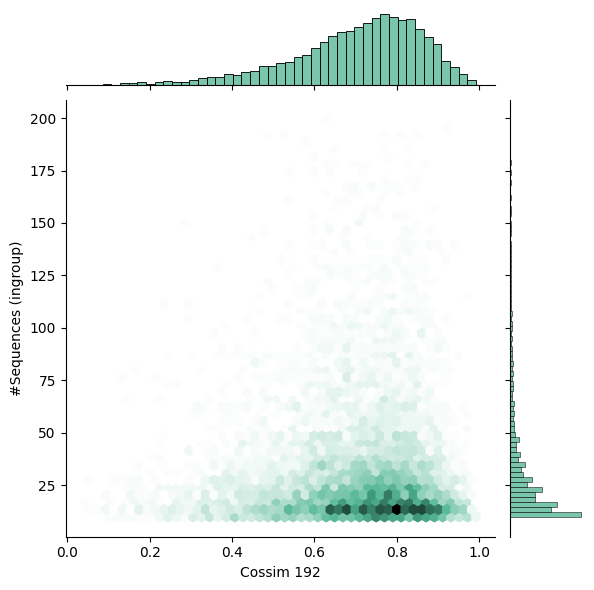

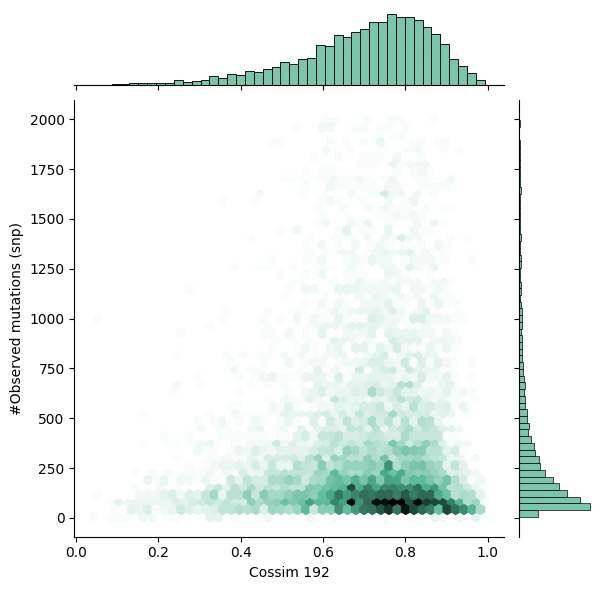

spectra2520_192
size: 7017
median: 0.68
mean: 0.66, std: 0.17


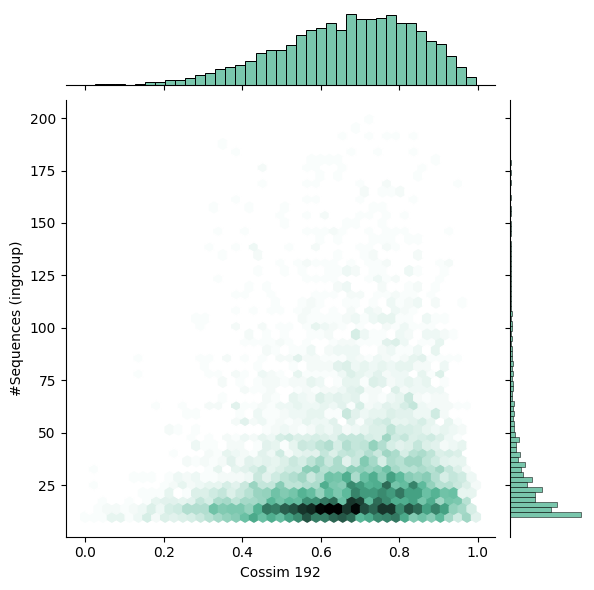

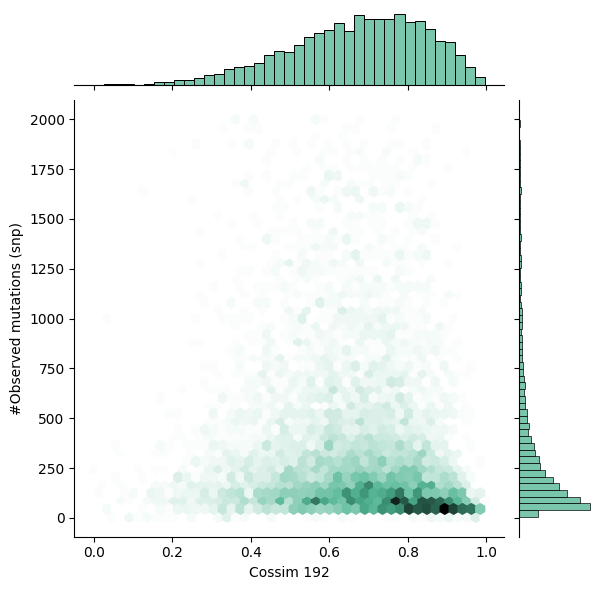

spectra1510_192
size: 7013
median: 0.62
mean: 0.61, std: 0.20


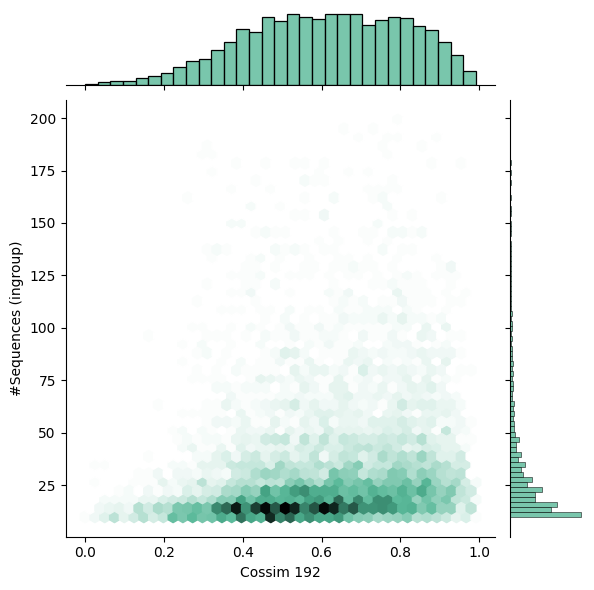

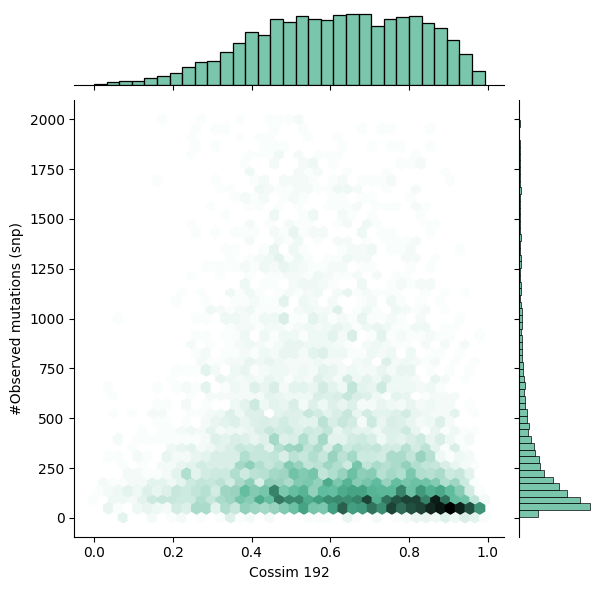

spectra0505_192
size: 3807
median: 0.49
mean: 0.51, std: 0.21


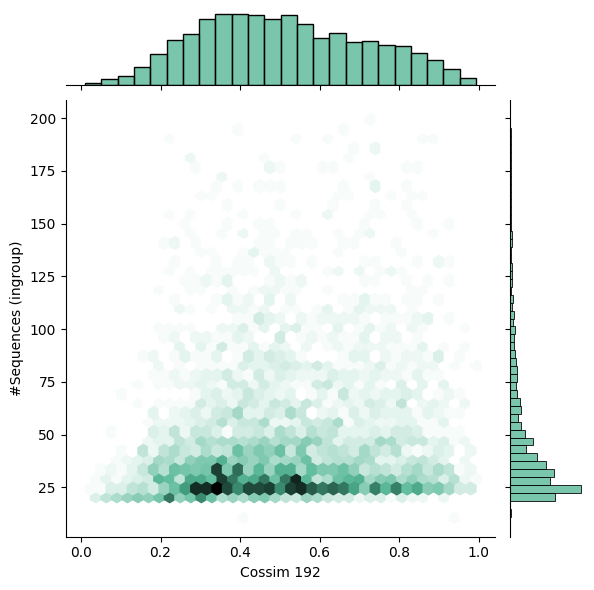

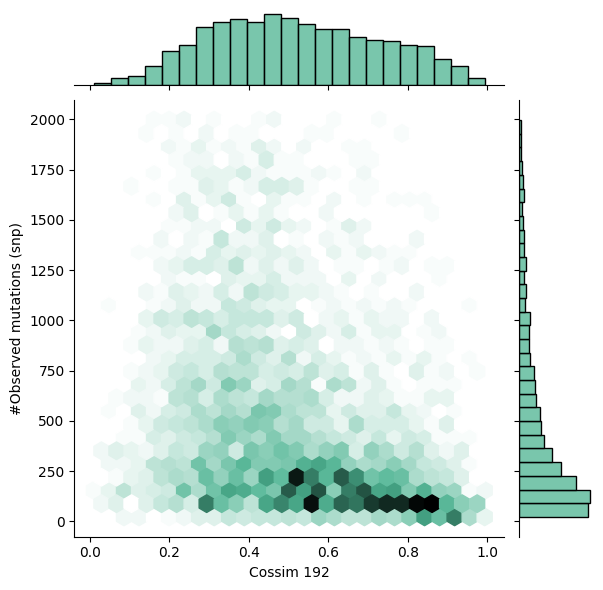

In [213]:
for df_snp, lbl in zip(
    [spectra0000_192, spectra2520_192, spectra1510_192, spectra0505_192],
    ['spectra0000_192', 'spectra2520_192', 'spectra1510_192', 'spectra0505_192']
):
    cossim = get_cossim(spectra192, df_snp)
    print(lbl)
    print(f'size: {cossim.shape[0]}\nmedian: {cossim.median():.2f}\nmean: {cossim.mean():.2f}, std: {cossim.std():.2f}')

    df192 = cossim.rename('cossim192').to_frame()\
        .merge(nobs, left_index=True, right_index=True).merge(nseqs, left_index=True, right_index=True)

    g = sns.jointplot(
        data=df192[df192.nseqs < 200],
        x="cossim192", y="nseqs", #hue="species",
        kind="hex", color="#4CB391"
    ).set_axis_labels("Cossim 192", "#Sequences (ingroup)");

    g = sns.jointplot(
        data=df192[df192.nobs < 2000],
        x="cossim192", y="nobs", #hue="species",
        kind="hex", color="#4CB391"
    ).set_axis_labels("Cossim 192", "#Observed mutations (snp)");
    plt.show()